 ## Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightning as pl
from simplelogger import SimpleLogger
from pathlib import Path
from lightning.pytorch.utilities.model_summary import ModelSummary
import sys

data_path = Path().cwd().parent / "data"

In [2]:
print(f"Python version -> {sys.version}")  # 3.12.3
print(f"torch version -> {torch.__version__}")  # 2.8.0+cu128
print(f"lightning version -> {pl.__version__}")  # 2.5.5

Python version -> 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
torch version -> 2.8.0+cu128
lightning version -> 2.5.5


 ## PL Data From CSV

In [3]:
data = pd.read_csv(data_path / "PL_data.csv", sep=";")

x = data[
    [
        "Headcount",
        "Mean",
        "Median",
        "Gini",
        "Population.Density",
        "Urban.Pop",
        "Age.Dependency",
    ]
]
y = data[["Poverty.Line.Month"]]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=123
)
x_train, x_test, y_train, y_test = (
    x_train.values,
    x_test.values,
    y_train.values,
    y_test.values,
)  # Transform pd.Dataframe to np arrays

 ## Data Normalization

In [ ]:
mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# mean_data = y_train.mean()
# std_data = y_train.std()

# y_train = (y_train - mean_data) / std_data
# y_test = (y_test - mean_data) / std_data


# convert to torch.tensor
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(
    y_train, dtype=torch.float32
)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(
    y_test, dtype=torch.float32
)


train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("x_train shape:", x_train.shape)
print("x_test shape :", x_test.shape)

x_train shape: torch.Size([385, 7])
x_test shape : torch.Size([97, 7])


/tmp/ipykernel_90853/3885344906.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(
/tmp/ipykernel_90853/3885344906.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(


 ## Model Definition

A neural network in pytorch must inherit from `pl.LightningModule` and implement a `forward` method.

By default, lightning uses Tensorboard if installed, or CSVlogger. I added this to keep track of losses in a quick and dirty way (self.manual_logs and self.running_loss)

  | Name       | Type       | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | activation | ReLU       | 0      | train | [1, 7]   | [1, 7]   
1 | layers     | Sequential | 4.5 K  | train | [1, 7]   | [1, 1]   
2 | mse        | MSELoss    | 0      | train | ?        | ?        
-------------------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


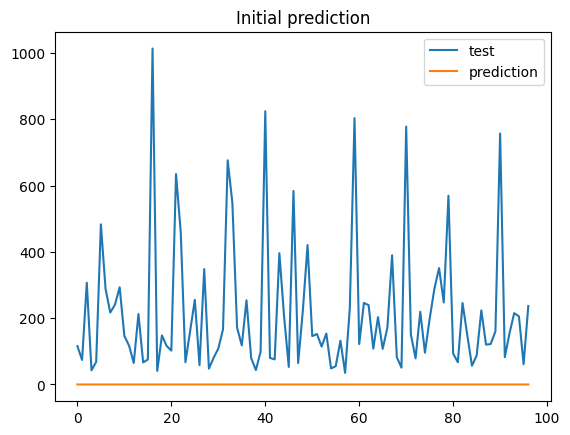

In [14]:
class PovertyLineModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super(PovertyLineModel, self).__init__()
        self.activation = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(7, 7),
            self.activation,
            nn.LazyLinear(32),
            self.activation,
            nn.LazyLinear(64),
            self.activation,
            nn.LazyLinear(32),
            self.activation,
            nn.LazyLinear(1),
        )
        self.mse = nn.MSELoss()
        self.lr = lr
        self.example_input_array = torch.zeros(1, 7)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.layers(x)
        loss = self.mse(yhat, y)
        mae = (yhat - y).abs().mean(1)
        self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"train_mae", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [optimizer]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.forward(x)
        loss = self.mse(yhat, y)
        self.log(f"val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log(f"val_mae", loss, on_step=False, on_epoch=True, prog_bar=True)


model = PovertyLineModel(lr=1e-4)
summary = ModelSummary(model)
print(summary)
plt.plot(y_test, label="test")
plt.plot(model(x_test).detach(), label="prediction")
plt.title("Initial prediction")
plt.legend()

 ## Train the Model

In [15]:
trainer = pl.Trainer(
    max_epochs=150,
    logger=SimpleLogger(),
    enable_checkpointing=False,
    log_every_n_steps=1,
)  # logger=False, enable_checkpointing=False to avoid polluting your workspace with lightning_logs and checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)


  | Name       | Type       | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | activation | ReLU       | 0      | train | [1, 7]   | [1, 7]   
1 | layers     | Sequential | 4.5 K  | train | [1, 7]   | [1, 1]   
2 | mse        | MSELoss    | 0      | train | ?        | ?        
-------------------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


/home/trappler/code/UP3_sandbox/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/trappler/code/UP3_sandbox/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Epoch 149: 100%|██████████| 49/49 [00:00<00:00, 280.70it/s, v_num=Data, val_loss=0.0607, val_mae=0.0607, train_loss=0.071, train_mae=0.071]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 49/49 [00:00<00:00, 279.32it/s, v_num=Data, val_loss=0.0607, val_mae=0.0607, train_loss=0.071, train_mae=0.071]


 ## Evaluate Model

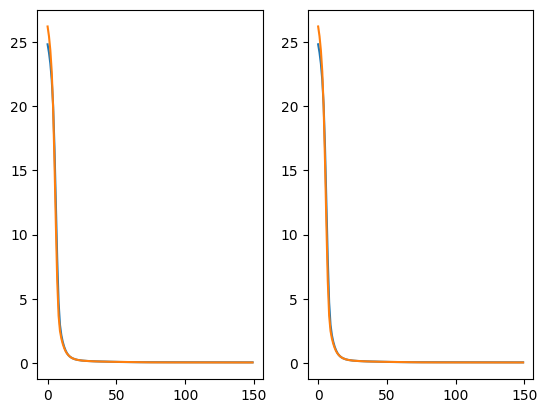

In [17]:
plt.subplot(1, 2, 1)
plt.plot(trainer.logger.metrics["train_loss"])
plt.plot(trainer.logger.metrics["val_loss"])
plt.subplot(1, 2, 2)
plt.plot(trainer.logger.metrics["train_mae"])
plt.plot(trainer.logger.metrics["val_mae"])

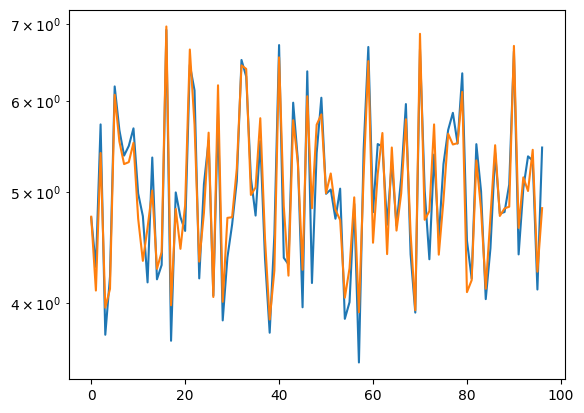

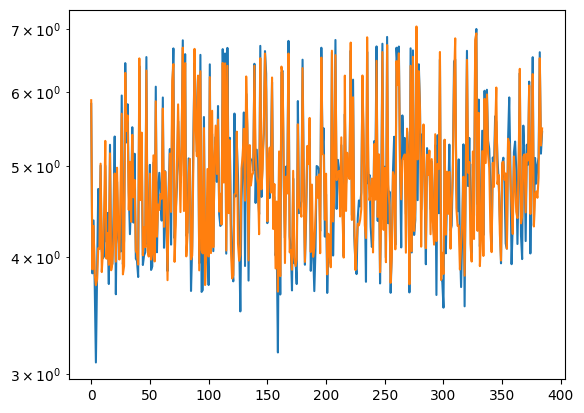

In [ ]:
plt.plot(y_test)
plt.plot(model(x_test).detach())
plt.yscale("log")
plt.show()
plt.plot(y_train)
plt.plot(model(x_train).detach())
plt.yscale("log")

 ## Prediction

In [ ]:
my_data = [-1.07, 1.02, 0.98, -0.41, -0.48, 0.69, -0.64]
real_PL = 337.29

my_data_tensor = torch.tensor(my_data).reshape(1, -1)

model.eval()
with torch.no_grad():
    prediction = model(my_data_tensor).item()
print(f"Prediction : {prediction:.2f} K$")
print(f"Reality    : {real_PL:.2f} K$")

Prediction : 256.34 K$
Reality    : 337.29 K$
